In [52]:
import os ,glob, numpy as np
import pandas as pd
from scipy import stats
from scipy.fftpack import fft
from scipy import signal
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [37]:
def Time_domain_statistics(a):
    s = stats.describe(a)
    return pd.DataFrame([s[2], s[3], s[4], s[5]]).stack()

In [3]:
def Inter_channel_statistics(a):
    f = []
    f.append(max(signal.correlate(a[2],a[3])))
    f.append(max(signal.correlate(a[1],a[3])))
    f.append(max(signal.correlate(a[1],a[2])))
    f.append(max(signal.correlate(a[0],a[3])))
    f.append(max(signal.correlate(a[0],a[2])))
    f.append(max(signal.correlate(a[0],a[1])))
    f.append(max(signal.correlate(a[6],a[7])))
    f.append(max(signal.correlate(a[5],a[7])))
    f.append(max(signal.correlate(a[5],a[6])))
    f.append(max(signal.correlate(a[4],a[7])))
    f.append(max(signal.correlate(a[3],a[6])))
    f.append(max(signal.correlate(a[4],a[5])))
    
    return pd.DataFrame(f)

In [4]:
def Log_moments_of_Fourier_spectra(a):
    S = a.apply(fft)
    Delta = S.apply(np.abs).pow(2)
    g = []
    I = pd.DataFrame([i for i in range(1, Delta.shape[0] + 1)])
    
    for i in range(7):
        nth = I.pow(i)
        res = pd.DataFrame(nth.values * Delta.values)
        res = res.sum(axis=0)
        res = res.apply(abs)
        res = res.pow(0.5)
        g.append(res)
        
    g = pd.DataFrame(np.array(g).T)
    
    feature = pd.DataFrame()
    feature = pd.concat([feature, g[0].apply(np.log)])
    feature = pd.concat([feature, g[2].apply(np.log)])
    feature = pd.concat([feature, g[4].apply(np.log)])
    feature = pd.concat([feature, g[0].apply(np.log) - (0.5)*(g[2] - g[0]).apply(np.log) - (0.5)*(g[4] - g[0]).apply(np.log)])
    feature = pd.concat([feature, g[2].apply(np.log) - (0.5)*(g[0] * g[4]).apply(np.log)])
    feature = pd.concat([feature, g[0].apply(np.log) - (0.5)*(g[1] * g[3]).apply(np.log)])
    feature = pd.concat([feature, g[0].apply(np.log) - (0.5)*(g[2] * g[6]).apply(np.log)])

    for i in range(1, 5):
        for j in range(2, 6):
            if(i < j):
                feature = pd.concat([feature, (0.5)*(g[i] * g[j]).apply(np.log)])
    
    return feature

In [5]:
def Spectral_band_powers(a):
    feature = pd.DataFrame()
    S = a.apply(fft)
    l = int(np.floor(len(S)/10))
    for k in range(0, 9*l, l):
        t = S.iloc[k:k+l]
        r = t.apply(abs).pow(2)
        r_sum = r.sum(axis=0)
        feature = pd.concat([feature, pd.DataFrame(r_sum)])
    
    t = S.iloc[l*9:len(S)]
    r = t.apply(abs).pow(2)
    r_sum = r.sum(axis=0)
    feature = pd.concat([feature, pd.DataFrame(r_sum)])

    return feature

In [6]:
def sign(val):
    return np.array(val > 0, dtype=np.int32)

def Local_binary_patterns(a):
    Nsigval = 6
    Ndown = 2
    Lbp = 1
    lbx = [i for i in range(-Nsigval//2, Nsigval//2 + 1) if(i != 0)]
    basisvec = [2**i for i in range(0, (2*Nsigval-91) + 1, Ndown)]
    abseg = a.apply(abs)    
    LCCP = pd.DataFrame()
    
    for gx1 in range(0,len(abseg)-Nsigval):
        gx = gx1 + Nsigval//2
        sig_local_vec = pd.DataFrame([abseg.iloc[gx+i] for i in lbx])
        Cv = abseg.iloc[gx-Lbp: gx+Lbp].apply(np.mean)
        tempVec = (sig_local_vec - Cv).apply(sign)
        LCCP = pd.concat([LCCP, pd.DataFrame(np.dot(basisvec, tempVec))], axis=1)
    
    ans = pd.DataFrame()
    for i in range(8):
        temp, _ = np.histogram(LCCP.iloc[i], 2)
        ans = pd.concat([ans, pd.DataFrame(temp)])
    return ans

In [7]:
def features(text_file):
    all_seg_features = pd.DataFrame()
    for i in range(len(text_file)):
        feature = pd.DataFrame()
        
        tds = Time_domain_statistics(text_file[i])
        feature = pd.concat([feature, tds])
        
        ics = Inter_channel_statistics(text_file[i])
        feature = pd.concat([feature, ics])
        
        lms = Log_moments_of_Fourier_spectra(text_file[i])
        feature = pd.concat([feature, lms])
        '''
        sbp = Spectral_band_powers(text_file[i])
        feature = pd.concat([feature, sbp])
        
        lbp = Local_binary_patterns(text_file[i])
        feature = pd.concat([feature, lbp])
        '''
        all_seg_features = pd.concat([all_seg_features, feature], axis=1)
    return all_seg_features.T

In [38]:
directory = "./EMGPhysicalActionDataSet"
searchFine   = os.path.join( directory, "sub*" )
filesFine = glob.glob( searchFine )

features_sub = pd.DataFrame()
Y = []
for i in filesFine:
    filesFolder = os.path.join(i,"Normal","txt")
    filesList = os.path.join( filesFolder, "*.txt" )
    files = glob.glob(filesList)
    for j in files:
        s = pd.read_csv(j, sep="\s+", header = None)
        dummy = []
        length_segment = int(np.floor(len(s)/15))
        remainder = len(s) - (15*length_segment)
        for k in range(0, 14*length_segment,length_segment):
            temp = s.iloc[k:k+length_segment]
            dummy.append(temp)
            Y.append(0)
        temp = s.iloc[length_segment*14:len(s)]
        dummy.append(temp)
        Y.append(0)
        
        dummy_features = features(dummy)
        
        features_sub = pd.concat([features_sub, dummy_features])
    print(filesFolder)
    
    filesFolder = os.path.join(i,"Aggressive","txt")
    filesList = os.path.join( filesFolder, "*.txt" )
    files = glob.glob(filesList)
    for j in files:
        s = pd.read_csv(j, sep="\s+", header = None)
        dummy = []
        length_segment = int(np.floor(len(s)/15))
        remainder = len(s) - (15*length_segment)
        for k in range(0, 14*length_segment,length_segment):
            temp = s.iloc[k:k+length_segment]
            dummy.append(temp)
            Y.append(1)
        temp = s.iloc[length_segment*14:len(s)]
        Y.append(1)
        dummy.append(temp)
        dummy_features = features(dummy)
        
        features_sub = pd.concat([features_sub, dummy_features])
        
    print(filesFolder)

./EMGPhysicalActionDataSet/sub1/Normal/txt
./EMGPhysicalActionDataSet/sub1/Aggressive/txt
./EMGPhysicalActionDataSet/sub3/Normal/txt
./EMGPhysicalActionDataSet/sub3/Aggressive/txt
./EMGPhysicalActionDataSet/sub2/Normal/txt
./EMGPhysicalActionDataSet/sub2/Aggressive/txt
./EMGPhysicalActionDataSet/sub4/Normal/txt
./EMGPhysicalActionDataSet/sub4/Aggressive/txt


In [39]:
features_sub = np.array(features_sub)
Y = np.array(Y)

print(features_sub.shape, Y.shape)

(1200, 180) (1200,)


In [47]:
# shuff = np.arange(0, 1200)
# np.random.shuffle(shuff)

############## UNCOMMENT TO REPRODUCE THE RESULTS
features_sub = np.load("features.npy")
shuff = np.load("shuffle.npy")
#################################################

features_sub = features_sub[shuff]
Y = Y[shuff]

Accuracy: 0.9666666666666667
[[61  3]
 [ 1 55]]
F1 score: 0.9649122807017544


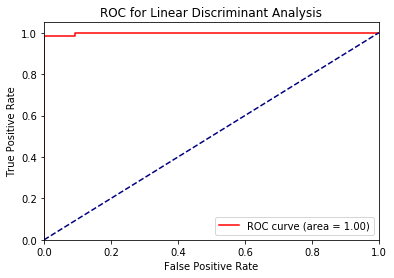

In [48]:
########################### LDA ########################
kf = KFold(n_splits=10)
temp = 0
for train, test in kf.split(features_sub):
    scaler = StandardScaler()
    features_sub_norm = scaler.fit_transform(features_sub[train])
    lda = LinearDiscriminantAnalysis()
    lda.fit(features_sub_norm, Y[train])
    features_sub_norm_test = scaler.transform(features_sub[test])
    acc = lda.score(features_sub_norm_test, Y[test])
    if(acc > temp):
        temp = acc
        LDA = lda
        test_data = [features_sub_norm_test, Y[test]]

lda_prd = LDA.predict(test_data[0])

print("Accuracy: %s" % (LDA.score(test_data[0], test_data[1])))
print(confusion_matrix(test_data[1], lda_prd))
print("F1 score: %s" % f1_score(test_data[1], lda_prd))
      
# ROC curve and finding area under the curve
y_score = LDA.decision_function(test_data[0])
fpr, tpr, thr = roc_curve(test_data[1], y_score)
roc_auc = auc(fpr, tpr)
# Plotting the curve
plt.figure()
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Linear Discriminant Analysis')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.9416666666666667
[[56  5]
 [ 2 57]]
F1 score: 0.9421487603305785


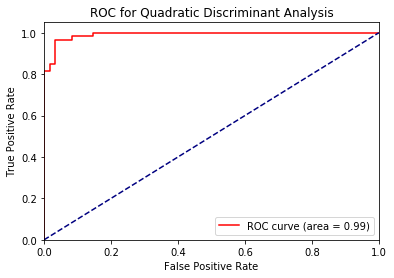

In [49]:
########################### QDA ########################
kf = KFold(n_splits=10)
temp = 0
for train, test in kf.split(features_sub):
    scaler = StandardScaler()
    features_sub_norm = scaler.fit_transform(features_sub[train])
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(features_sub_norm, Y[train])
    features_sub_norm_test = scaler.transform(features_sub[test])
    acc = qda.score(features_sub_norm_test, Y[test])
    if(acc > temp):
        temp = acc
        QDA = qda
        test_data = [features_sub_norm_test, Y[test]]

qda_prd = QDA.predict(test_data[0])

print("Accuracy: %s" % (QDA.score(test_data[0], test_data[1])))
print(confusion_matrix(test_data[1], qda_prd))
print("F1 score: %s" % f1_score(test_data[1], qda_prd))

# ROC curve and finding area under the curve
y_score = QDA.decision_function(test_data[0])
fpr, tpr, thr = roc_curve(test_data[1], y_score)
roc_auc = auc(fpr, tpr)
# Plotting the curve
plt.figure()
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Quadratic Discriminant Analysis')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.975
[[58  2]
 [ 1 59]]
F1 score: 0.9752066115702478


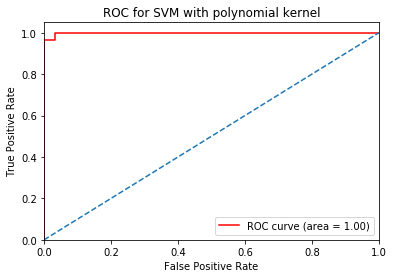

In [50]:
########################### SVM with polynomial kernel ########################
kf = KFold(n_splits=10)
temp = 0
for train, test in kf.split(features_sub):
    scaler = StandardScaler()
    features_sub_norm = scaler.fit_transform(features_sub[train])
    p_svm = svm.SVC(C=10, kernel='poly', gamma='scale', degree=2)
    p_svm.fit(features_sub_norm, Y[train])
    features_sub_norm_test = scaler.transform(features_sub[test])
    acc = p_svm.score(features_sub_norm_test, Y[test])
    if(acc > temp):
        temp = acc
        P_SVM = p_svm
        test_data = [features_sub_norm_test, Y[test]]

p_svm_prd = P_SVM.predict(test_data[0])

print("Accuracy: %s" % (P_SVM.score(test_data[0], test_data[1])))
print(confusion_matrix(test_data[1], p_svm_prd))
print("F1 score: %s" % f1_score(test_data[1], p_svm_prd))

# ROC curve and finding area under the curve
y_score = P_SVM.decision_function(test_data[0])
fpr, tpr, thr = roc_curve(test_data[1], y_score)
roc_auc = auc(fpr, tpr)
# Plotting the curve
plt.figure()
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SVM with polynomial kernel')
plt.legend(loc="lower right")
plt.show()

Accuracy: 1.0
[[52  0]
 [ 0 68]]
F1 score: 1.0


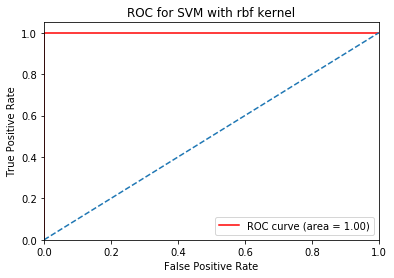

In [51]:
########################### SVM with rbf kernel ########################
kf = KFold(n_splits=10)
temp = 0
for train, test in kf.split(features_sub):
    scaler = StandardScaler()
    features_sub_norm = scaler.fit_transform(features_sub[train])
    g_svm = svm.SVC(C=10, gamma='scale')
    g_svm.fit(features_sub_norm, Y[train])
    features_sub_norm_test = scaler.transform(features_sub[test])
    acc = g_svm.score(features_sub_norm_test, Y[test])
    if(acc > temp):
        temp = acc
        G_SVM = g_svm
        test_data = [features_sub_norm_test, Y[test]]

g_svm_prd = G_SVM.predict(test_data[0])

print("Accuracy: %s" % (G_SVM.score(test_data[0], test_data[1])))
print(confusion_matrix(test_data[1], g_svm_prd))
print("F1 score: %s" % f1_score(test_data[1], g_svm_prd))


# ROC curve and finding area under the curve
y_score = G_SVM.decision_function(test_data[0])
fpr, tpr, thr = roc_curve(test_data[1], y_score)
roc_auc = auc(fpr, tpr)
# Plotting the curve
plt.figure()
plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SVM with rbf kernel')
plt.legend(loc="lower right")
plt.show()

In [45]:
########################### KNN ########################
kf = KFold(n_splits=10)
temp = 0
for train, test in kf.split(features_sub):
    scaler = StandardScaler()
    features_sub_norm = scaler.fit_transform(features_sub[train])
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(features_sub_norm, Y[train])
    features_sub_norm_test = scaler.transform(features_sub[test])
    acc = neigh.score(features_sub_norm_test, Y[test])
    if(acc > temp):
        temp = acc
        KNN = neigh
        test_data = [features_sub_norm_test, Y[test]]

knn_prd = KNN.predict(test_data[0])

print("Accuracy: %s" % (KNN.score(test_data[0], test_data[1])))
print(confusion_matrix(test_data[1], knn_prd))
print("F1 score: %s" % f1_score(test_data[1], knn_prd))

Accuracy: 0.9916666666666667
[[65  0]
 [ 1 54]]
F1 score: 0.9908256880733944


In [46]:
### TO SAVE THE FEATURES ###

# np.save("features.npy", features_sub)